# DeepHyper Analytics for Neural Architecture Search - Single Study
**path to data log directory**: data_2021-07-14_01.json

for customization please see: https://matplotlib.org/api/matplotlib_configuration_api.html

## Setup & Data loading

In [1]:
path_to_logdir = '/home/bwilson/DL/deephyper'

In [2]:
import os
import json
from pprint import pprint
from datetime import datetime

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display, Markdown

from deephyper.core.logs.topk import output_best_configuration

In [3]:
init_infos_path = os.path.join(path_to_logdir, "init_infos.json")
results_path = os.path.join(path_to_logdir, "results.csv")
balsam_workload_path = os.path.join(path_to_logdir, "balsam-workload.json")

In [4]:
def to_sec(ts):
    try:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').timestamp()
    except:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f').timestamp()

def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

print(f"init_infos_path: {init_infos_path}")
init_infos = load_json(init_infos_path)
results_df = pd.read_csv(results_path)
try:
    balsam_workload = load_json(balsam_workload_path)
except FileNotFoundError:
    print("Balsam workload not found...")

start_timestamp = init_infos["start_timestamp"]
print(list(init_infos.keys()))

init_infos_path: /home/bwilson/DL/deephyper/init_infos.json
Balsam workload not found...
['start_timestamp', 'num_workers', 'max_evals', 'problem']


### Matplotlib style

In [5]:
width = 8
height = width / 1.618

fontsize = 27
legend_font_size = 23
# fontsize = 18
# legend_font_size = 12
matplotlib.rcParams.update(
    {
        "font.size": fontsize,
        "figure.figsize": (width, height),
        "figure.facecolor": "white",
        "savefig.dpi": 72,
        "figure.subplot.bottom": 0.125,
        "figure.edgecolor": "white",
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "lines.linewidth": 3,
    }
)

@ticker.FuncFormatter
def hour_major_formatter(x, pos):
    x = float(f"{x/3600:.2f}")
    if x % 1 == 0:
        x = str(int(x))
    else:
        x = f"{x:.2f}"
    return x

In [6]:
def moving_average(data_list, window_size=100):
    res_list = list()
    for i in range(len(data_list) - window_size):
            res_list.append(sum(data_list[i:i+window_size])/window_size)
    return res_list

## Best configuration(s)

In [7]:
output_best_configuration(results_path, "", k=3)

'0':
  arch_seq: '[0.8323024001314224, 0.7889290619064494, 0.9385678954207153, 0.16059637997392429,
    0.6488539744120456, 0.8325765404421139, 0.9888735139157468, 0.9322143923769549,
    0.7933123406870071]'
  elapsed_sec: 89.9581792355
  id: 678aa6f4-e42d-11eb-a964-f18f9b2aeba1
  objective: 1.0
'1':
  arch_seq: '[0.11650447341058867, 0.5875885504875177, 0.7616171130499415, 0.40112081475681394,
    0.7493532265120827, 0.2800965658218403, 0.31393139677072335, 0.165157311048022,
    0.8629399531678635]'
  elapsed_sec: 1583.2949447632
  id: 02a893d0-e431-11eb-aa27-f18f9b2aeba1
  objective: 1.0
'2':
  arch_seq: '[0.33164869729598867, 0.20248330614152665, 0.2547469587010932, 0.015167333255724169,
    0.2775206010994029, 0.9916415578893681, 0.4538746929355745, 0.21892060220106446,
    0.9121595786916527]'
  elapsed_sec: 1584.8581268787
  id: 039cd79e-e431-11eb-aa27-f18f9b2aeba1
  objective: 1.0



## Information about evaluations

In [8]:
display(Markdown(f"{len(results_df)} evaluations"))
display(Markdown(f"{len(np.unique(results_df.arch_seq))} unique architectures"))

26332 evaluations

26332 unique architectures

## Search trajectory


### Scatter Plot

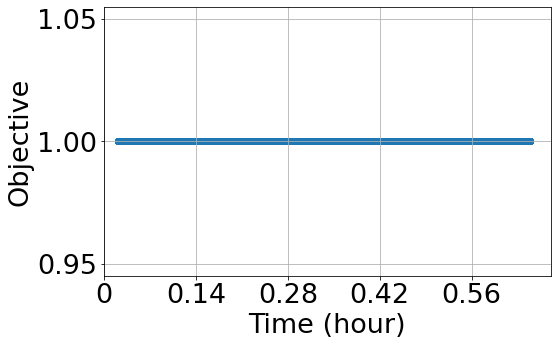

In [9]:
plt.figure()

plt.scatter(results_df.elapsed_sec, results_df.objective)

plt.ylabel("Objective")
plt.xlabel("Time (hour)")

plt.xlim(0)

ax = plt.gca()
ax.xaxis.set_major_formatter(hour_major_formatter)

plt.grid()
plt.show()

## Balsam Workload
### Profile

In [10]:
times = [to_sec(t)-start_timestamp for t in balsam_workload['timestamps']]
num_running = (np.array(balsam_workload['num_jobs_running']) - 1)
try:
    nworkers = init_infos['num_workers']
except:
    nworkers = int(input('How many workers do you have ?'))
num_running_norm = num_running / nworkers

plt.fill_between(times, num_running_norm, step="post", label='real')
plt.plot(moving_average(times), moving_average(num_running_norm), 'r:', linewidth=3, label='avrg')

plt.xlabel('Time (s)')
plt.ylabel('Node utilization')
plt.xlim(0)
plt.ylim(0)
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_formatter(hour_major_formatter)

plt.grid()
plt.show()

NameError: name 'balsam_workload' is not defined

### Pie chart

In [11]:
def integrate_square(x, y, offset=0):
    res = 0
    for i in range(len(x)-1):
        res += (x[i+1] - x[i]) * y[i]
    return res

nworkers = init_infos['num_workers']
total_available = nworkers * times[-1]
used_time = integrate_square(times, num_running)
unused_time = total_available - used_time
perc_used_time = int(used_time / total_available * 100)
perc_unused_time = int(unused_time / total_available * 100)
label_used_time = f'{perc_used_time}% used'
label_unused_time = f'{perc_unused_time}% unused'
lpie = plt.pie([used_time, unused_time],
               labels=[label_used_time, label_unused_time],
               colors=['green', 'red'])
plt.show()

NameError: name 'times' is not defined